## Initializing a SparkSession

### Execute the cell below and:

- Select Add Endpoint
- Select Single Sign-On
- Select Create Session, selecting language as Python and in properties use "spark.kubernetes.container.image": "gcr.io/mapr-252711/spark-whylogs-3.5.1:v3.5.1.0.1" the whylogs -integerated spark image in properties.
- Click Create Session

When your session is ready the Manage Sessions pane will become active, providing you the session ID. The session state will become idle which means that you are good to go!
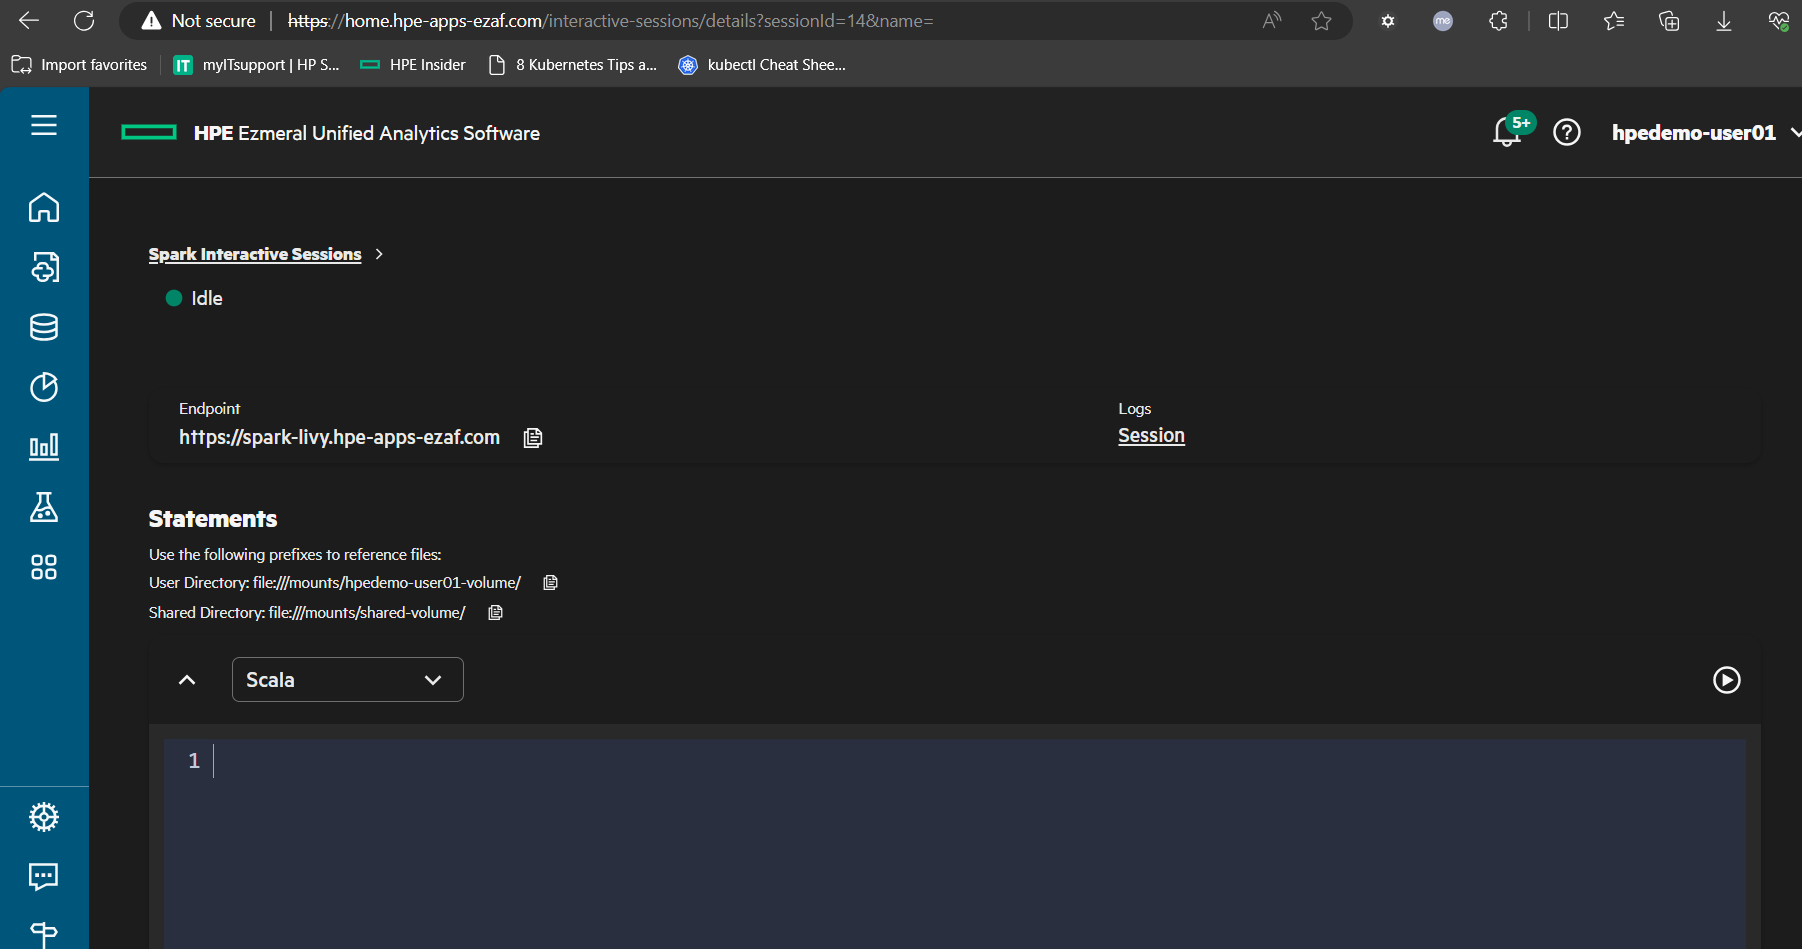

In [1]:
%manage_spark

MagicsControllerWidget(children=(Tab(children=(ManageSessionWidget(children=(HTML(value='<br/>'), HTML(value='…

In [2]:
import os
os.environ['HTTP_PROXY'] = "http://hpeproxy.its.hpecorp.net:443"
os.environ['HTTPS_PROXY'] = "http://hpeproxy.its.hpecorp.net:443"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('whylogs-testing').getOrCreate()
arrow_config_key = "spark.sql.execution.arrow.pyspark.enabled"
spark.conf.set(arrow_config_key, "true")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For the sake of simplicity, we will read the Wine Quality dataset, available in this URL: "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv".

In [9]:
from pyspark import SparkFiles
spark_dataframe= spark.read.format('csv').option("header","true").option("delimiter", ";").option("inferSchema","true").load("file:///mounts/shared-volume/shared/winequality-red.csv")

spark_dataframe.show(n=1, vertical=True)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

-RECORD 0----------------------
 fixed acidity        | 7.4    
 volatile acidity     | 0.7    
 citric acid          | 0.0    
 residual sugar       | 1.9    
 chlorides            | 0.076  
 free sulfur dioxide  | 11.0   
 total sulfur dioxide | 34.0   
 density              | 0.9978 
 pH                   | 3.51   
 sulphates            | 0.56   
 alcohol              | 9.4    
 quality              | 5      
only showing top 1 row

### __Profiling the data with whylogs__
Now that we have a Spark DataFrame in place, let's see how easy it is to profile our data with whylogs.

In [10]:
import whylogs
from whylogs.api.pyspark.experimental import collect_column_profile_views

column_views_dict = collect_column_profile_views(spark_dataframe)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Yeap. It's done. 
But what do we get with a column_views_dict?

In [11]:
print(column_views_dict)
print((column_views_dict.keys()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'alcohol': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d12dbb0>, 'chlorides': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d13f5e0>, 'citric acid': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d143160>, 'density': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d146940>, 'fixed acidity': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d00d310>, 'free sulfur dioxide': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d015070>, 'pH': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3acb6a8280>, 'quality': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d01e6d0>, 'residual sugar': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d0213d0>, 'sulphates': <whylogs.core.view.column_profile_view.ColumnProfileView object at 0x7f3a6d027130>, 'total sulfur dioxide

It is a dictionary with one ColumnProfileView object per column in your dataset. And we can inspect some of the metrics on each one of them, such as the counts for a given column

In [12]:
column_views_dict["density"].get_metric("counts").n.value, spark_dataframe.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1599, 1599)

Or their mean value:

In [13]:
column_views_dict["density"].get_metric("distribution").mean.value

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.9967466791744841

And now let's check how accurate whylogs did store that mean calculation.

In [14]:
from pyspark.sql.functions import mean
spark_dataframe.select(mean("density")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|      avg(density)|
+------------------+
|0.9967466791744831|
+------------------+

It is not the literal exact value, but it gets really close, right? That is because we are not extracting the exact information, but we are also not sampling the data. whylogs will look at every data point and statistically decide wether or not that data point is relevant to the final calculation.

In [15]:
from whylogs.api.pyspark.experimental import collect_dataset_profile_view

dataset_profile_view = collect_dataset_profile_view(input_df=spark_dataframe)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
import pandas as pd 

dataset_profile_view.to_pandas().head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               cardinality/est  cardinality/lower_1  ...  ints/max  ints/min
column                                               ...                    
alcohol              65.000010            65.000000  ...       NaN       NaN
chlorides           153.000058           153.000000  ...       NaN       NaN
citric acid          80.000016            80.000000  ...       NaN       NaN
density             439.557368           433.943761  ...       NaN       NaN
fixed acidity        96.000023            96.000000  ...       NaN       NaN

[5 rows x 31 columns]